In [2]:
import math
import random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# seed value for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
def read_audio(x):
    y = librosa.load(x)[0]
    return librosa.util.fix_length(y, size=11025)

In [6]:
def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)
    

In [5]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0]

In [7]:
clinical_data = pd.read_csv("Clinical_Meta.csv")
metadata_solicited = pd.read_csv("Solicited_Meta.csv")
metadata_solicited

,participant,filename,sound_prediction_score
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039
...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813


In [8]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = 'solicited/' + metadata_solicited['filename']

# add all other colums from clinical data to metadata 
for col in clinical_data.columns:
    if col not in metadata_solicited.columns:
        metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())

# print columns
print(metadata_solicited.columns)


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_50593/3002384670.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_50593/3002384670.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())
/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_50593/3002384670.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` i

Index(['participant', 'filename', 'sound_prediction_score', 'label',
       'relative_path', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status'],
      dtype='object')


In [9]:
metadata_solicited['sex'] = metadata_solicited['sex'].map({'Male': 0, 'Female': 1})
metadata_solicited['tb_prior'] = metadata_solicited['tb_prior'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Pul'] = metadata_solicited['tb_prior_Pul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Extrapul'] = metadata_solicited['tb_prior_Extrapul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Unknown'] = metadata_solicited['tb_prior_Unknown'].map({'No': 0, 'Yes': 1})
metadata_solicited['hemoptysis'] = metadata_solicited['hemoptysis'].map({'No': 0, 'Yes': 1})
metadata_solicited['weight_loss'] = metadata_solicited['weight_loss'].map({'No': 0, 'Yes': 1})
metadata_solicited['smoke_lweek'] = metadata_solicited['smoke_lweek'].map({'No': 0, 'Yes': 1})
metadata_solicited['fever'] = metadata_solicited['fever'].map({'No': 0, 'Yes': 1})
metadata_solicited['night_sweats'] = metadata_solicited['night_sweats'].map({'No': 0, 'Yes': 1})

# count number of NaN values
print(metadata_solicited.isnull().sum())


participant                0
filename                   0
sound_prediction_score     0
label                      0
relative_path              0
sex                        0
age                        0
height                    23
weight                     0
reported_cough_dur         0
tb_prior                  23
tb_prior_Pul               0
tb_prior_Extrapul          0
tb_prior_Unknown           0
hemoptysis                 0
heart_rate                 0
temperature                0
weight_loss                0
smoke_lweek                0
fever                      0
night_sweats               0
tb_status                  0
dtype: int64


In [10]:
# drop NaN values
metadata_solicited = metadata_solicited.dropna()

metadata_solicited

,participant,filename,sound_prediction_score,label,relative_path,sex,age,height,weight,reported_cough_dur,...,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,solicited/1645088710003-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,solicited/1645088760390-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,solicited/1645088760830-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,solicited/1645088710843-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,solicited/1645088759950-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,0,solicited/1658214018804-recording-1.wav,1,50,174.0,87.3,30,...,0,0,0,70,37.0,0,0,1,0,0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,0,solicited/1658213992939-recording-1.wav,1,50,174.0,87.3,30,...,0,0,0,70,37.0,0,0,1,0,0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,0,solicited/1658213992139-recording-1.wav,1,50,174.0,87.3,30,...,0,0,0,70,37.0,0,0,1,0,0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,0,solicited/1658213940569-recording-1.wav,1,50,174.0,87.3,30,...,0,0,0,70,37.0,0,0,1,0,0


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique participant IDs and their counts
participants_counts = metadata_solicited['participant'].value_counts()

# Initialize empty DataFrames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# Determine the number of participants for each split (adjust ratio as needed)
train_participants, test_participants = train_test_split(participants_counts.index, test_size=0.2, random_state=42)


# Filter data based on the selected participants
df_train = metadata_solicited[metadata_solicited['participant'].isin(train_participants)]
df_test = metadata_solicited[metadata_solicited['participant'].isin(test_participants)]

# Double-check to ensure participants are only in one split
assert set(df_train['participant'].unique()) & set(df_test['participant'].unique()) == set()

# Now, df_train contains approximately 80% of the participants, and df_test contains approximately 20%


In [15]:
from sklearn.model_selection import train_test_split

# Assuming `df` is your DataFrame and `audio_files` is the column with audio file names
df_train, df_test = train_test_split(metadata_solicited, test_size=0.2, random_state=42)

# Now `df_train` and `df_test` are your training and testing sets

In [12]:
# check which split participant CODA_TB_0001 is in with if else
participant_id = 'CODA_TB_0003'

if df_train['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the train set')
if df_test['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the test set')


CODA_TB_0003 is in the train set


In [13]:
df_train

,participant,filename,sound_prediction_score,label,relative_path,sex,age,height,weight,reported_cough_dur,...,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,solicited/1645088710003-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,solicited/1645088760390-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,solicited/1645088760830-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,solicited/1645088710843-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,solicited/1645088759950-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9760,CODA_TB_1106,1640314212030-recording-1.wav,0.998949,1,solicited/1640314212030-recording-1.wav,1,63,154.0,48.0,90,...,0,0,0,100,36.9,0,0,0,0,1
9761,CODA_TB_1106,1640314211430-recording-1.wav,0.999861,1,solicited/1640314211430-recording-1.wav,1,63,154.0,48.0,90,...,0,0,0,100,36.9,0,0,0,0,1
9762,CODA_TB_1106,1640314196015-recording-1.wav,0.999981,1,solicited/1640314196015-recording-1.wav,1,63,154.0,48.0,90,...,0,0,0,100,36.9,0,0,0,0,1
9763,CODA_TB_1106,1640314174840-recording-1.wav,0.999981,1,solicited/1640314174840-recording-1.wav,1,63,154.0,48.0,90,...,0,0,0,100,36.9,0,0,0,0,1


##### Read all the files (train, test and val) and converting them into mel-spectrogram images

In [14]:
list_audio_train = []
for i in df_train['relative_path']:
    list_audio_train.append(read_audio(i))

In [15]:
list_audio_test = []
for i in df_test['relative_path']:
    list_audio_test.append(read_audio(i))

In [16]:
mel_spectrogram_train = np.array(list(map(calc_mel_spectrogram, list_audio_train)))
mel_spectrogram_test = np.array(list(map(calc_mel_spectrogram, list_audio_test)))

In [17]:
print(df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1))

      sex  age  height  weight  reported_cough_dur  tb_prior  tb_prior_Pul  \
0       0   27   173.3    63.0                  30       0.0             0   
1       0   27   173.3    63.0                  30       0.0             0   
2       0   27   173.3    63.0                  30       0.0             0   
3       0   27   173.3    63.0                  30       0.0             0   
4       0   27   173.3    63.0                  30       0.0             0   
...   ...  ...     ...     ...                 ...       ...           ...   
9760    1   63   154.0    48.0                  90       0.0             0   
9761    1   63   154.0    48.0                  90       0.0             0   
9762    1   63   154.0    48.0                  90       0.0             0   
9763    1   63   154.0    48.0                  90       0.0             0   
9764    1   63   154.0    48.0                  90       0.0             0   

      tb_prior_Extrapul  tb_prior_Unknown  hemoptysis  heart_ra

In [18]:
from sklearn.preprocessing import StandardScaler
# Mel spectrogram data
X_mel_train = np.expand_dims(mel_spectrogram_train, -1)
X_mel_test = np.expand_dims(mel_spectrogram_test, -1)

# Tabular data
X_tabular_train = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status', 'heart_rate', 'temperature', 'fever'], axis=1).values  
print(X_tabular_train.shape)
X_tabular_test = df_test.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status', 'heart_rate', 'temperature', 'fever'], axis=1).values
print(X_tabular_test.shape)
# Labels
y_train = df_train['label']
y_test = df_test['label']


# # Save all data to files
# np.save('X_mel_train.npy', X_mel_train)
# np.save('X_mel_val.npy', X_mel_val)
# np.save('X_mel_test.npy', X_mel_test)
# np.save('X_tabular_train.npy', X_tabular_train)
# np.save('X_tabular_val.npy', X_tabular_val)
# np.save('X_tabular_test.npy', X_tabular_test)
# np.save('y_train.npy', y_train)
# np.save('y_val.npy', y_val)
# np.save('y_test.npy', y_test)



(7748, 13)
(1978, 13)


In [19]:
X_tabular_test.shape


(1978, 13)

In [20]:
print(df_test.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status', 'heart_rate', 'temperature', 'fever'], axis=1))

      sex  age  height  weight  reported_cough_dur  tb_prior  tb_prior_Pul  \
42      0   28   170.5    53.0                  14       0.0             0   
43      0   28   170.5    53.0                  14       0.0             0   
44      0   28   170.5    53.0                  14       0.0             0   
45      0   28   170.5    53.0                  14       0.0             0   
46      0   28   170.5    53.0                  14       0.0             0   
...   ...  ...     ...     ...                 ...       ...           ...   
9767    1   50   174.0    87.3                  30       0.0             0   
9768    1   50   174.0    87.3                  30       0.0             0   
9769    1   50   174.0    87.3                  30       0.0             0   
9770    1   50   174.0    87.3                  30       0.0             0   
9771    1   50   174.0    87.3                  30       0.0             0   

      tb_prior_Extrapul  tb_prior_Unknown  hemoptysis  weight_l

In [202]:
# # save each split to ONE file, and add column letting us know which split it is
# df_train['split'] = 'train'
# df_val['split'] = 'val'
# df_test['split'] = 'test'
# df_all = pd.concat([df_train, df_val, df_test])
# df_all.to_csv('solicited-audio-split.csv', index=False)


In [21]:
# # load split df and save to each split
# df_all = pd.read_csv('solicited-audio-split.csv')
# df_train = df_all[df_all['split']=='train']
# df_val = df_all[df_all['split']=='val']
# df_test = df_all[df_all['split']=='test']

# # load data from files
# X_mel_train = np.load('X_mel_train.npy')
# X_mel_val = np.load('X_mel_val.npy')
# X_mel_test = np.load('X_mel_test.npy')
# X_tabular_train = np.load('X_tabular_train.npy')
# X_tabular_val = np.load('X_tabular_val.npy')
# X_tabular_test = np.load('X_tabular_test.npy')
# y_train = np.load('y_train.npy')
# y_val = np.load('y_val.npy')
# y_test = np.load('y_test.npy')


print(df_test.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1).columns)
print(X_tabular_test[0])
print(y_train)
# print ratio of positive and negative in df_train
print(df_train['label'].value_counts())

Index(['sex', 'age', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
       'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
       'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek', 'fever',
       'night_sweats'],
      dtype='object')
[  0.   28.  170.5  53.   14.    0.    0.    0.    0.    0.    0.    0.
   1. ]
0       0
1       0
2       0
3       0
4       0
       ..
9760    1
9761    1
9762    1
9763    1
9764    1
Name: label, Length: 7748, dtype: int64
label
0    5412
1    2336
Name: count, dtype: int64


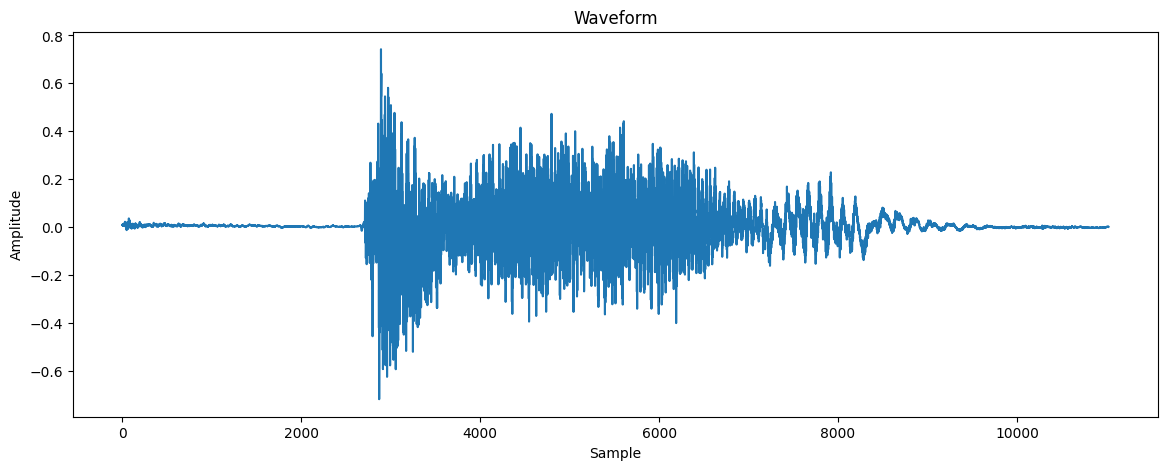

In [22]:
import matplotlib.pyplot as plt

# Assuming list_audio_train[0] contains your audio data and sr is the sample rate
plt.figure(figsize=(14, 5))
plt.plot(list_audio_train[8])
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

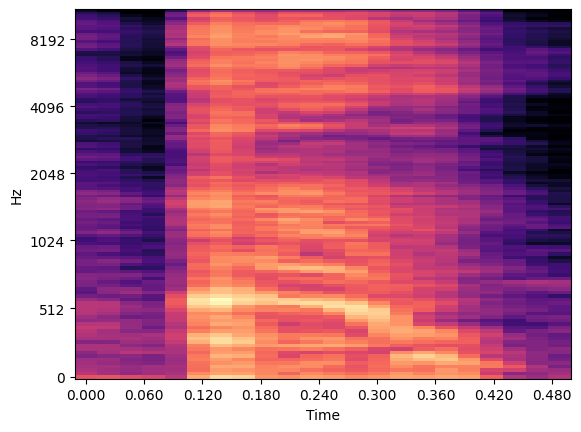

In [23]:
librosa.display.specshow(mel_spectrogram_train[8], y_axis='mel', x_axis='time', auto_aspect=True)
#plt.savefig()

In [24]:
print(X_tabular_train.shape[1])

13


In [26]:
from tensorflow.keras import layers, models

# Define the model
mel_input_shape = X_mel_train.shape[1:]  
tabular_input_shape = X_tabular_train.shape[1]

# Gated Activation Unit (GAU)
def gated_activation_unit(x):
    tanh_out = layers.Activation('tanh')(x)
    sigmoid_out = layers.Activation('sigmoid')(x)
    return layers.Multiply()([tanh_out, sigmoid_out])

# Multi-Head Self-Attention
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, heads, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0

        self.depth = self.d_model // self.heads

        self.query_dense = layers.Dense(self.d_model)
        self.key_dense = layers.Dense(self.d_model)
        self.value_dense = layers.Dense(self.d_model)

        self.combine_heads = layers.Dense(self.d_model)

    def call(self, inputs, **kwargs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split the heads
        query = layers.Reshape((self.heads, self.depth))(query)
        key = layers.Reshape((self.heads, self.depth))(key)
        value = layers.Reshape((self.heads, self.depth))(value)

        # Apply scaled dot-product attention
        attention = layers.Attention()([query, key, value])
        attention = layers.Reshape((self.d_model,))(attention)

        # Combine heads
        output = self.combine_heads(attention)
        return output

# Model architecture
mel_input = layers.Input(shape=mel_input_shape, name='mel_input')
x = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(mel_input)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512)(x)
x = gated_activation_unit(x)

# Tabular input
tabular_input = layers.Input(shape=(tabular_input_shape,), name='tabular_input')
y = layers.Dense(512)(tabular_input)
y = layers.Dense(256)(tabular_input)
y = layers.Dropout(0.2)(y)

# Multi-Head Self-Attention
attention = MultiHeadSelfAttention(heads=8)(x)
weighted_x = layers.Multiply()([x, attention])

# Concatenate the paths
combined = layers.Concatenate()([weighted_x, y])

# Dense layers for final classification
z = layers.Dense(1024, activation='leaky_relu')(combined)
z = layers.LayerNormalization()(z)
z = layers.Dense(256, activation='leaky_relu')(z)
z = layers.Dropout(0.1)(z)
output = layers.Dense(1, activation='sigmoid', name='output')(z)

# Create the model
model = models.Model(inputs={'mel_input': mel_input, 'tabular_input': tabular_input}, outputs=output)

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_input (InputLayer)      [(None, 128, 22, 1)]         0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 22, 64)          640       ['mel_input[0][0]']           
                                                                                                  
 layer_normalization_3 (Lay  (None, 128, 22, 64)          128       ['conv2d_2[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 64, 11, 64)           0         ['layer_normalization_3[

In [27]:
# Model architecture
mel_input = layers.Input(shape=mel_input_shape, name='mel_input')
x = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(mel_input)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)

# Tabular input
tabular_input = layers.Input(shape=(tabular_input_shape,), name='tabular_input')
y = layers.Dense(512)(tabular_input)
y = layers.Dense(256)(tabular_input)
y = layers.Dropout(0.1)(y)

# Concatenate the paths
combined = layers.Concatenate()([x, y])

# Dense layers for final classification
z = layers.Dense(1024, activation='leaky_relu')(combined)
z = layers.LayerNormalization()(z)
z = layers.Dense(256, activation='leaky_relu')(z)
output = layers.Dense(1, activation='sigmoid', name='output')(z)

# Create the model
model = models.Model(inputs={'mel_input': mel_input, 'tabular_input': tabular_input}, outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_input (InputLayer)      [(None, 128, 22, 1)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 22, 64)          640       ['mel_input[0][0]']           
                                                                                                  
 layer_normalization_6 (Lay  (None, 128, 22, 64)          128       ['conv2d_4[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 11, 64)           0         ['layer_normalization_6[

In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(y_true, y_pred, alpha=0.70, gamma=2):
    # Calculate the focal loss
    ce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    fl_loss = alpha * tf.pow(1 - pt, gamma) * ce_loss
    return fl_loss

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def s_plus_s(y_true, y_pred):
    return sensitivity(y_true, y_pred) + specificity(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss=binary_crossentropy,
    metrics=['accuracy', 'AUC']
)


In [32]:
EPOCHS = 50

try:
    history = model.fit(
        {'mel_input': X_mel_train, 'tabular_input': X_tabular_train},
        y_train,
        epochs=EPOCHS,
        validation_data=({'mel_input': X_mel_test, 'tabular_input': X_tabular_test}, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=15, restore_best_weights=True),
        ]
    )
except KeyboardInterrupt:
    print("Training interrupted manually.")


Epoch 1/50


In [ ]:
# save model
# model.save('dec-27-new-model.h5')

# load model
# model = models.load_model('dec-27-model.h5', custom_objects={'MultiHeadSelfAttention': MultiHeadSelfAttention, 'gated_activation_unit': gated_activation_unit, 'focal_loss': focal_loss})

In [49]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_test, 'tabular_input': X_tabular_test})
roc_auc_score(y_test, y_pred)

# add probability to df_test
df_test['probability'] = y_pred

# save df_test to csv
df_test.to_csv('solicited-audio-test.csv', index=False)


62/62 [==============================] - 1s 17ms/step


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_18508/768982515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['probability'] = y_pred


In [1]:
def calculate_metrics():
    roc_auc_score(df['label'], df['probability'])

    # print auc  and auc curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(df['label'], df['probability'])
    print("AUC:", roc_auc_score(df['label'], df['probability']))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    print("Sensitivity:", tpr[optimal_idx])
    print("Specificity:", 1 - fpr[optimal_idx])

    # print the optimal confusion matrix using seaborn
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['label'], y_pred_2)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # print classification report
    from sklearn.metrics import classification_report
    target_names = ['No TB', 'TB']
    print(classification_report(df['label'], y_pred_2, target_names=target_names))

    # get the specificity when the sensitivity is 0.90
    sensitivity = 0.90
    idx = np.argwhere(np.diff(np.sign(tpr - sensitivity))).flatten()
    specificity = 1 - fpr[idx]
    print("Specificity at 90% sensitivity:", specificity)


df_test.loc[:, 'probability'] = y_pred

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.25)
df.to_csv('25th-Percentile-Predictions.csv', index=False)
print("25th Percentile Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.75)
df.to_csv('75th-Percentile-Predictions.csv', index=False)
print("75th Percentile Metrics:")
calculate_metrics()



NameError: name 'y_pred' is not defined

Index(['participant', 'filename', 'sound_prediction_score', 'label',
       'relative_path', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status'],
      dtype='object')


Index(['sex', 'age', 'height', 'weight', 'reported_cough_dur', 'tb_prior',
       'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown', 'hemoptysis',
       'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek', 'fever',
       'night_sweats'],
      dtype='object')
244/244 [==============================] - 4s 16ms/step


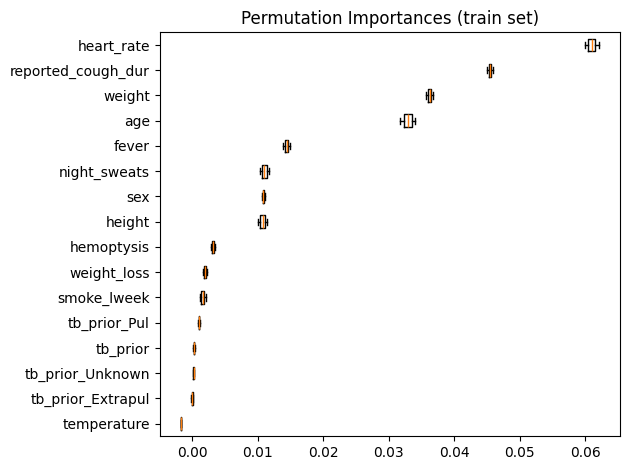

In [50]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Get the feature names
feature_names = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1).columns
print(feature_names)

def wrapper_predict(X):
    return model.predict([X_mel_train, X])

def keras_accuracy(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, np.round(y_pred))

class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return wrapper_predict(X)

# Create a wrapped model
wrapped_model = KerasWrapper(model)

# Use the wrapped model with permutation_importance
result = permutation_importance(wrapped_model, X_tabular_train, y_train, scoring=keras_accuracy, n_repeats=2, random_state=42, n_jobs=1)

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

# Plot the permutation importances
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(feature_names)[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

